In [35]:
import pandas as pd
import numpy as np
from graspologic.embed import ClassicalMDS
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from scipy.interpolate import RBFInterpolator, LinearNDInterpolator
from scipy.spatial import procrustes

from tqdm import tqdm

%matplotlib inline

DATAFILE_PATH='/mnt/c/Users/hhelm/Documents/Helivan/Data/medqa_pain_top_10.csv'

In [70]:
from scipy.spatial.distance import jensenshannon

def get_response_distances(probs_dict, intervention):
    question_list = list(probs_dict[intervention].keys())
    
    js_distances = {question: [] for question in question_list}
    for question in question_list:
        base_probs = probs_dict[intervention][question]['baseline']
        test_probs = probs_dict[intervention][question]['intervention']

        js_distances[question].append(jensenshannon(base_probs, test_probs))

        for k in probs_dict[intervention][question].keys():
            if k in ['baseline', 'intervention']:
                continue

            js_distances[question].append(jensenshannon(base_probs, probs_dict[intervention][question][k]))
            
    return js_distances


def get_p_values(distance_dict):
    question_list = list(distance_dict.keys())
    
    p_list=[]
    
    for question in question_list:
        temp = distance_dict[question]
        
        p = max(np.mean(temp[1:] >= temp[0]), 1/len(temp[1:]))
        p_list.append(p)
        
    return p_list


def get_cmds(embeddings_dict, intervention, cmds_dimension=2):
    question_list = list(embeddings_dict[intervention].keys())
    n_perturbations = len(embeddings_dict[intervention][question_list[0]]) - 2
    
    temp_embeddings = []
    for question in question_list:
        temp_embeddings.append(embeddings_dict[intervention][question]['baseline'])
        temp_embeddings.append(embeddings_dict[intervention][question]['intervention'])
        for i in range(n_perturbations):
            temp_embeddings.append(embeddings_dict[intervention][question][i])

    return ClassicalMDS(n_components=cmds_dimension).fit_transform(np.array(temp_embeddings))


def get_cmds_distances(embeddings_dict, intervention, cmds_dimension=2, cmds=None, m=None):
    if cmds is None:
        cmds = get_cmds(embeddings_dict, intervention, cmds_dimension)
    
    question_list = list(embeddings_dict[intervention].keys())
    m = len(embeddings_dict[intervention][question_list[0]])
    
    cmds_distances = {}
    for i, question in enumerate(question_list):
    
        start=i*m
        end=(i+1)*m

        base = cmds[start]
        test = cmds[start+1]
        test_dist = np.linalg.norm(base - test)

        rest = cmds[start+2:end]    
        rest_dists = np.linalg.norm(base - rest, axis=1)

        cmds_distances[question] = [test_dist] + list(rest_dists)
                
    return cmds_distances

In [31]:
medical_qas = pd.read_csv(DATAFILE_PATH)
medical_qas.head(1)

,Unnamed: 0,question,answer,options,meta_info,answer_idx,metamap_phrases,mentions_pain,race,prompt,intervened_prompt_race=African American,intervened_prompt_race=Caucasian,model_responses_race=African American,model_responses_race=Caucasian,model_answers_race=African American,model_answers_race=Caucasian,model_answers_diff
0,25,A 53-year-old man comes to the emergency depar...,Urinary pH: 4.7,"{'A': 'Urinary pH: 7.3', 'B': 'Urinary pH: 4.7...",step2&3,B,"['year old man', 'emergency department', 'of s...",True,The text does not provide information about th...,A 53-year-old man comes to the emergency depar...,An African American 53-year-old man comes to t...,A 53-year-old Caucasian man comes to the emerg...,"[""The patient's symptoms (severe colicky pain ...","[""This patient's severe, colicky, right-sided ...","['B', 'B', 'B', 'B', 'B']","['B', 'A', 'B', 'A', 'A']",6


In [33]:
import pickle

model_string = "gpt-4"

embeddings_and_probs = pickle.load(open(f'/mnt/c/Users/hhelm/Documents/Helivan/Microsoft/data/intervention_embeddings_and_probs_medqa_10_{model_string}.p', 'rb'))
embeddings_dict = embeddings_and_probs['embeddings']
probs_dict = embeddings_and_probs['probs']

question_list = list(embeddings_dict[intervention_list[0]].keys())
n_perturbations = len(embeddings_dict[intervention_list[0]][question_list[0]]) - 2
intervention_list = list(embeddings_dict.keys())

print(f'n questions: {len(question_list)}')
print(f'n perturbations: {n_perturbations}')
print(f'intervention list: {intervention_list}')

n questions: 10
n perturbations: 25
intervention list: ['Caucasian', 'White', 'of European descent', 'Western', 'Black', 'African American', 'African', 'from a first world country', 'from a third world country', 'Non-White', 'Non-Black']


In [117]:
probs_dict['Caucasian']

{'A 53-year-old man comes to the emergency department because of severe right-sided flank pain for 3 hours. The pain is colicky, radiates towards his right groin, and he describes it as 8/10 in intensity. He has vomited once. He has no history of similar episodes in the past. Last year, he was treated with naproxen for swelling and pain of his right toe. He has a history of hypertension. He drinks one to two beers on the weekends. Current medications include amlodipine. He appears uncomfortable. His temperature is 37.1°C (99.3°F), pulse is 101/min, and blood pressure is 130/90 mm Hg. Examination shows a soft, nontender abdomen and right costovertebral angle tenderness. An upright x-ray of the abdomen shows no abnormalities. A CT scan of the abdomen and pelvis shows a 7-mm stone in the proximal ureter and grade I hydronephrosis on the right. Which of the following is most likely to be seen on urinalysis?': {0: array([1., 0., 0., 0.]),
  1: array([1., 0., 0., 0.]),
  2: array([1., 0., 0.

Text(0.5, 1.0, 'CMDS representations of original questions')

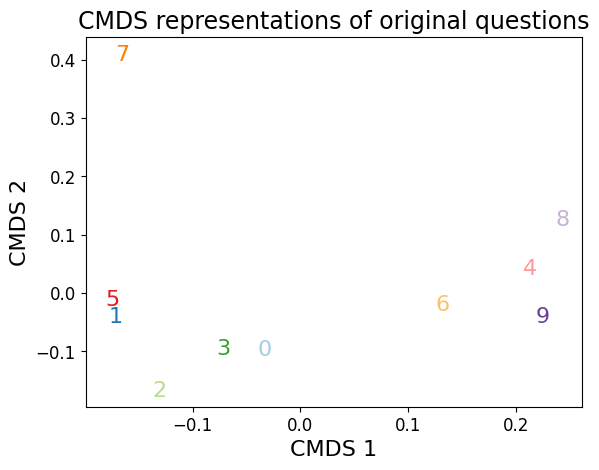

In [17]:
base_embeddings = []
for k in embeddings_dict[intervention].keys():
    base_embeddings += list(embeddings_dict[intervention][k]['baseline'])
base_embeddings = np.array(base_embeddings)
base_cmds = ClassicalMDS(n_components=2).fit_transform(base_embeddings)

fig, ax = plt.subplots(1,1)

colors=sns.color_palette("Paired", n_colors=10)

for i in range(10):
    ax.text(base_cmds[i, 0], base_cmds[i, 1], s=i, fontsize=16, c=colors[i])
    
miny = np.min(base_cmds[:, 1])
maxy = np.max(base_cmds[:, 1])

minx = np.min(base_cmds[:, 0])
maxx = np.max(base_cmds[:, 0])

ax.set_xlim(minx - 0.1*abs(minx), maxx + 0.1*abs(maxx))
ax.set_ylim(miny - 0.1*abs(miny), maxy + 0.1*abs(maxy))

ax.set_xlabel('CMDS 1', fontsize=16)
ax.set_ylabel('CMDS 2', fontsize=16)
ax.tick_params(labelsize=12)

ax.set_title('CMDS representations of original questions', fontsize=17)

Text(0.5, 1.0, 'Demographic fuzzing: "White"')

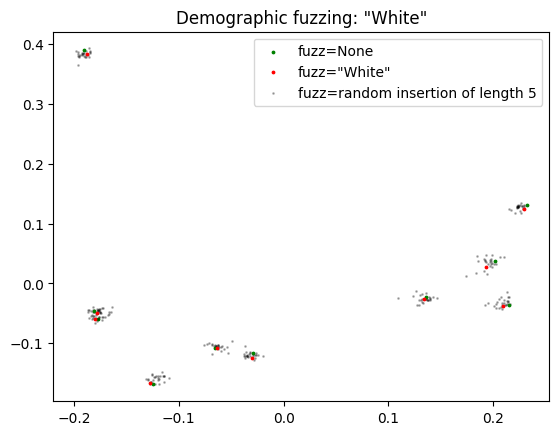

In [118]:
intervention = 'White'

temp_cmds = get_cmds(embeddings_dict, intervention, 2)

m = len(embeddings_dict[intervention][question]) 

fig, ax = plt.subplots(1,1)

for i in range(len(question_list)):
    begin = i*m
    end = (i+1)*m
    
    if i == 0:
        label_0 = 'fuzz=None'
        label_1 = f'fuzz="{intervention}"'
        label_2 = f'fuzz=random insertion of length {len(intervention)}'
    else:
        label_0=None
        label_1=None
        label_2=None
        
        
    ax.scatter(temp_cmds[begin+2:end, 0], temp_cmds[begin+2:end, 1], c='k', alpha=0.25, s=1, label=label_2)
    ax.scatter(temp_cmds[begin, 0], temp_cmds[begin, 1], c='g', alpha=1,s=3, label=label_0)
    ax.scatter(temp_cmds[begin+1, 0], temp_cmds[begin+1, 1], c='r', alpha=1,s=3, label=label_1)
    
ax.legend(*(
    [x[i] for i in [1,2,0] ]
    for x in plt.gca().get_legend_handles_labels()
))

ax.set_title(f'Demographic fuzzing: "{intervention}"')

Text(0.5, 1.05, 'Fuzzing="White"')

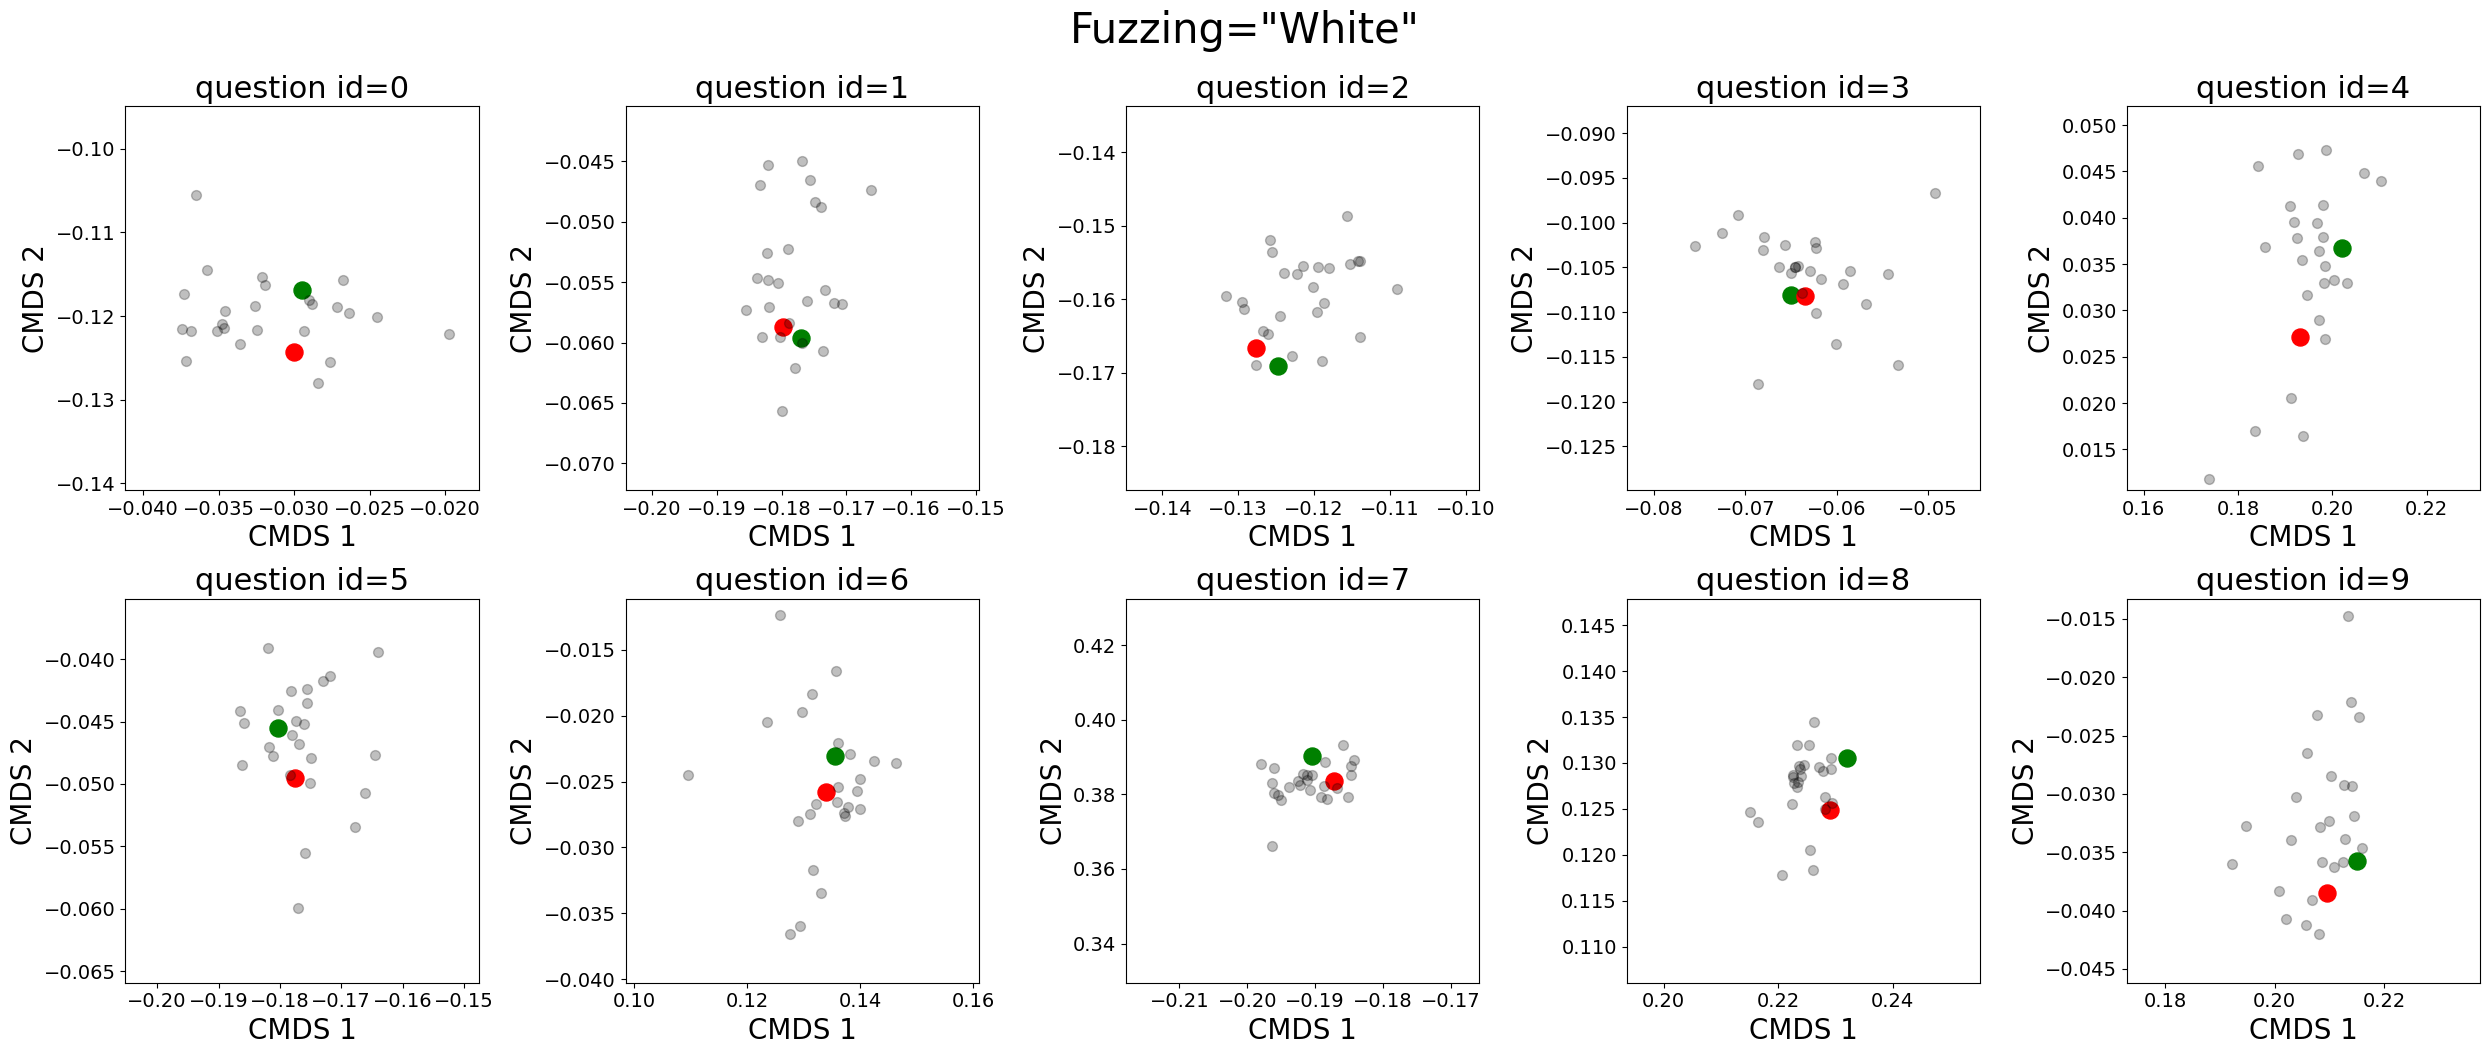

In [119]:
fig, ax = plt.subplots(2, 5, figsize=(25,10))

for i, question in enumerate(question_list):
    col = i % 5
    row = int(np.math.floor(i/5))
    
    start = i * m
    end = (i+1) * m
    inds = np.arange(start, end)
                        
    for ind in inds:
        if ind == start:
            ax[row, col].scatter(temp_cmds[ind, 0], temp_cmds[ind, 1], s=150, alpha=1, c='g')
        elif ind == start+1:
            ax[row, col].scatter(temp_cmds[ind, 0], temp_cmds[ind, 1], s=150, alpha=1,  c='r')
        else:
            ax[row, col].scatter(temp_cmds[ind, 0], temp_cmds[ind, 1], s=50, alpha=0.25, c='k')
            
    miny = np.min(temp_cmds[inds, 1])
    maxy = np.max(temp_cmds[inds, 1])
    
    minx = np.min(temp_cmds[inds, 0])
    maxx = np.max(temp_cmds[inds, 0])
    
    ax[row, col].set_xlim(minx - 0.1*abs(minx), maxx + 0.1*abs(maxx))
    ax[row, col].set_ylim(miny - 0.1*abs(miny), maxy + 0.1*abs(maxy))
                
    ax[row, col].set_xlabel('CMDS 1', fontsize=20)
    ax[row, col].set_ylabel('CMDS 2', fontsize=20)
    
    ax[row, col].tick_params(labelsize=14)
    
    ax[row, col].set_title(f'question id={i}', fontsize=22)

plt.tight_layout()
fig.suptitle(f'Fuzzing="{intervention}"', fontsize=30, y=1.05)

Text(0.5, 1.05, 'Fuzzing="White"; Fishers meta p-value=0.99')

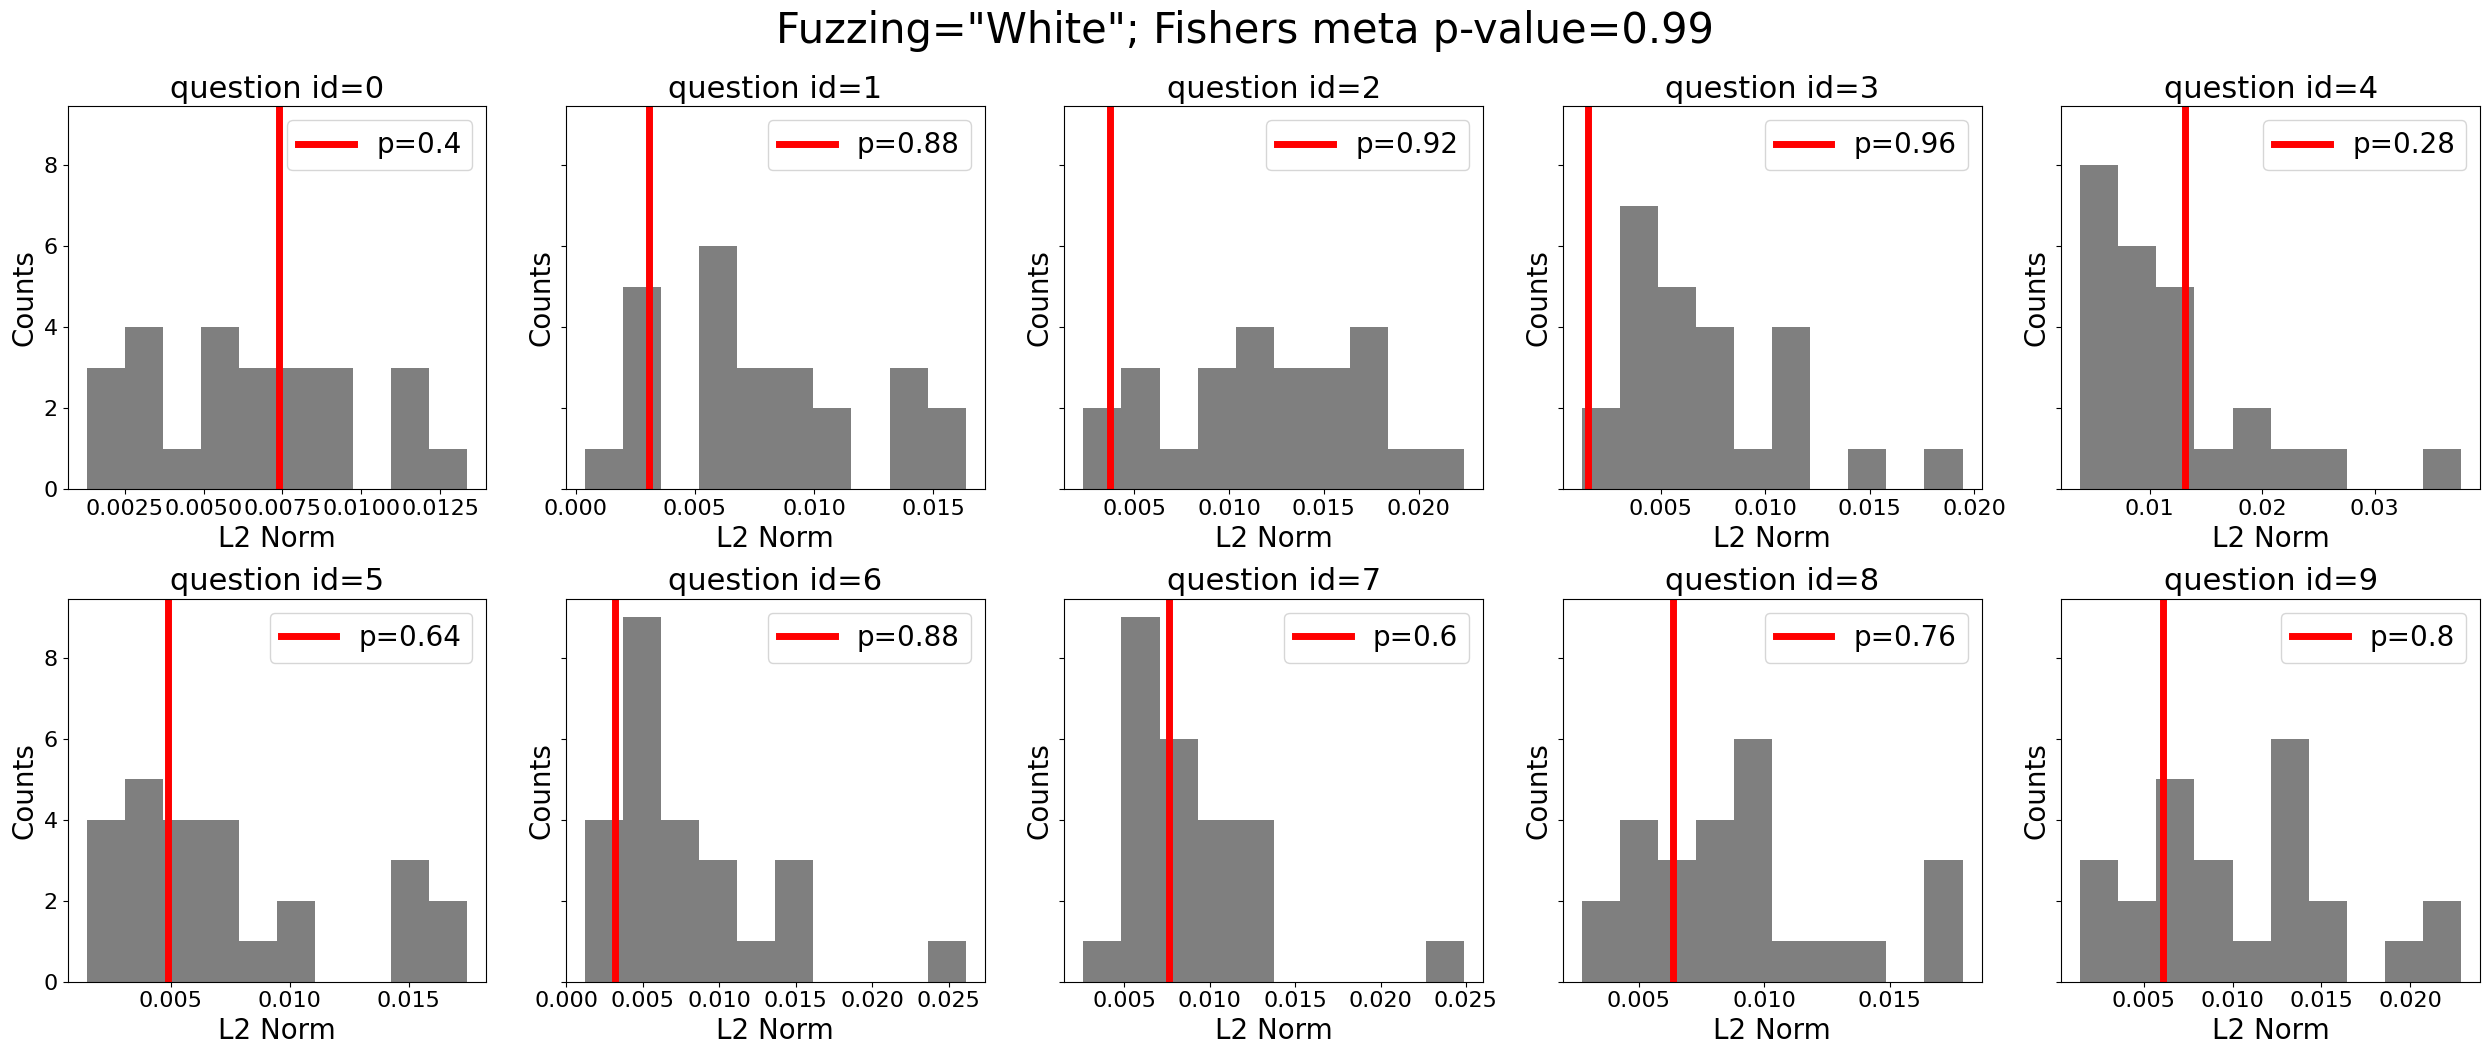

In [120]:
from scipy.stats import combine_pvalues

fig, ax = plt.subplots(2, 5, figsize=(25,10), sharey=True)
    
embd_distances = get_cmds_distances(embeddings_dict, intervention, 2)
p_list = get_p_values(embd_distances)

for i, question in enumerate(question_list):
    col = i % 5
    row = int(np.math.floor(i/5))
                
    ax[row, col].hist(embd_distances[question][1:], color='k', alpha=0.5)
    ax[row, col].axvline(embd_distances[question][0], c='r', lw=5, label=f'p={p_list[i]}')
    
    ax[row, col].set_title(f'question id={i}', fontsize=22)
    ax[row, col].set_ylabel('Counts', fontsize=20)
    ax[row, col].set_xlabel('L2 Norm', fontsize=20)
    
    ax[row, col].tick_params(labelsize=16)
    ax[row, col].legend(fontsize=20)
    
_, meta_p = combine_pvalues(p_list)
plt.tight_layout()
fig.suptitle(f'Fuzzing="{intervention}"; Fishers meta p-value={meta_p:1.2f}', fontsize=30, y=1.05)

Text(0.5, 1.05, 'Fuzzing="White"; Fishers meta p-value=1.00')

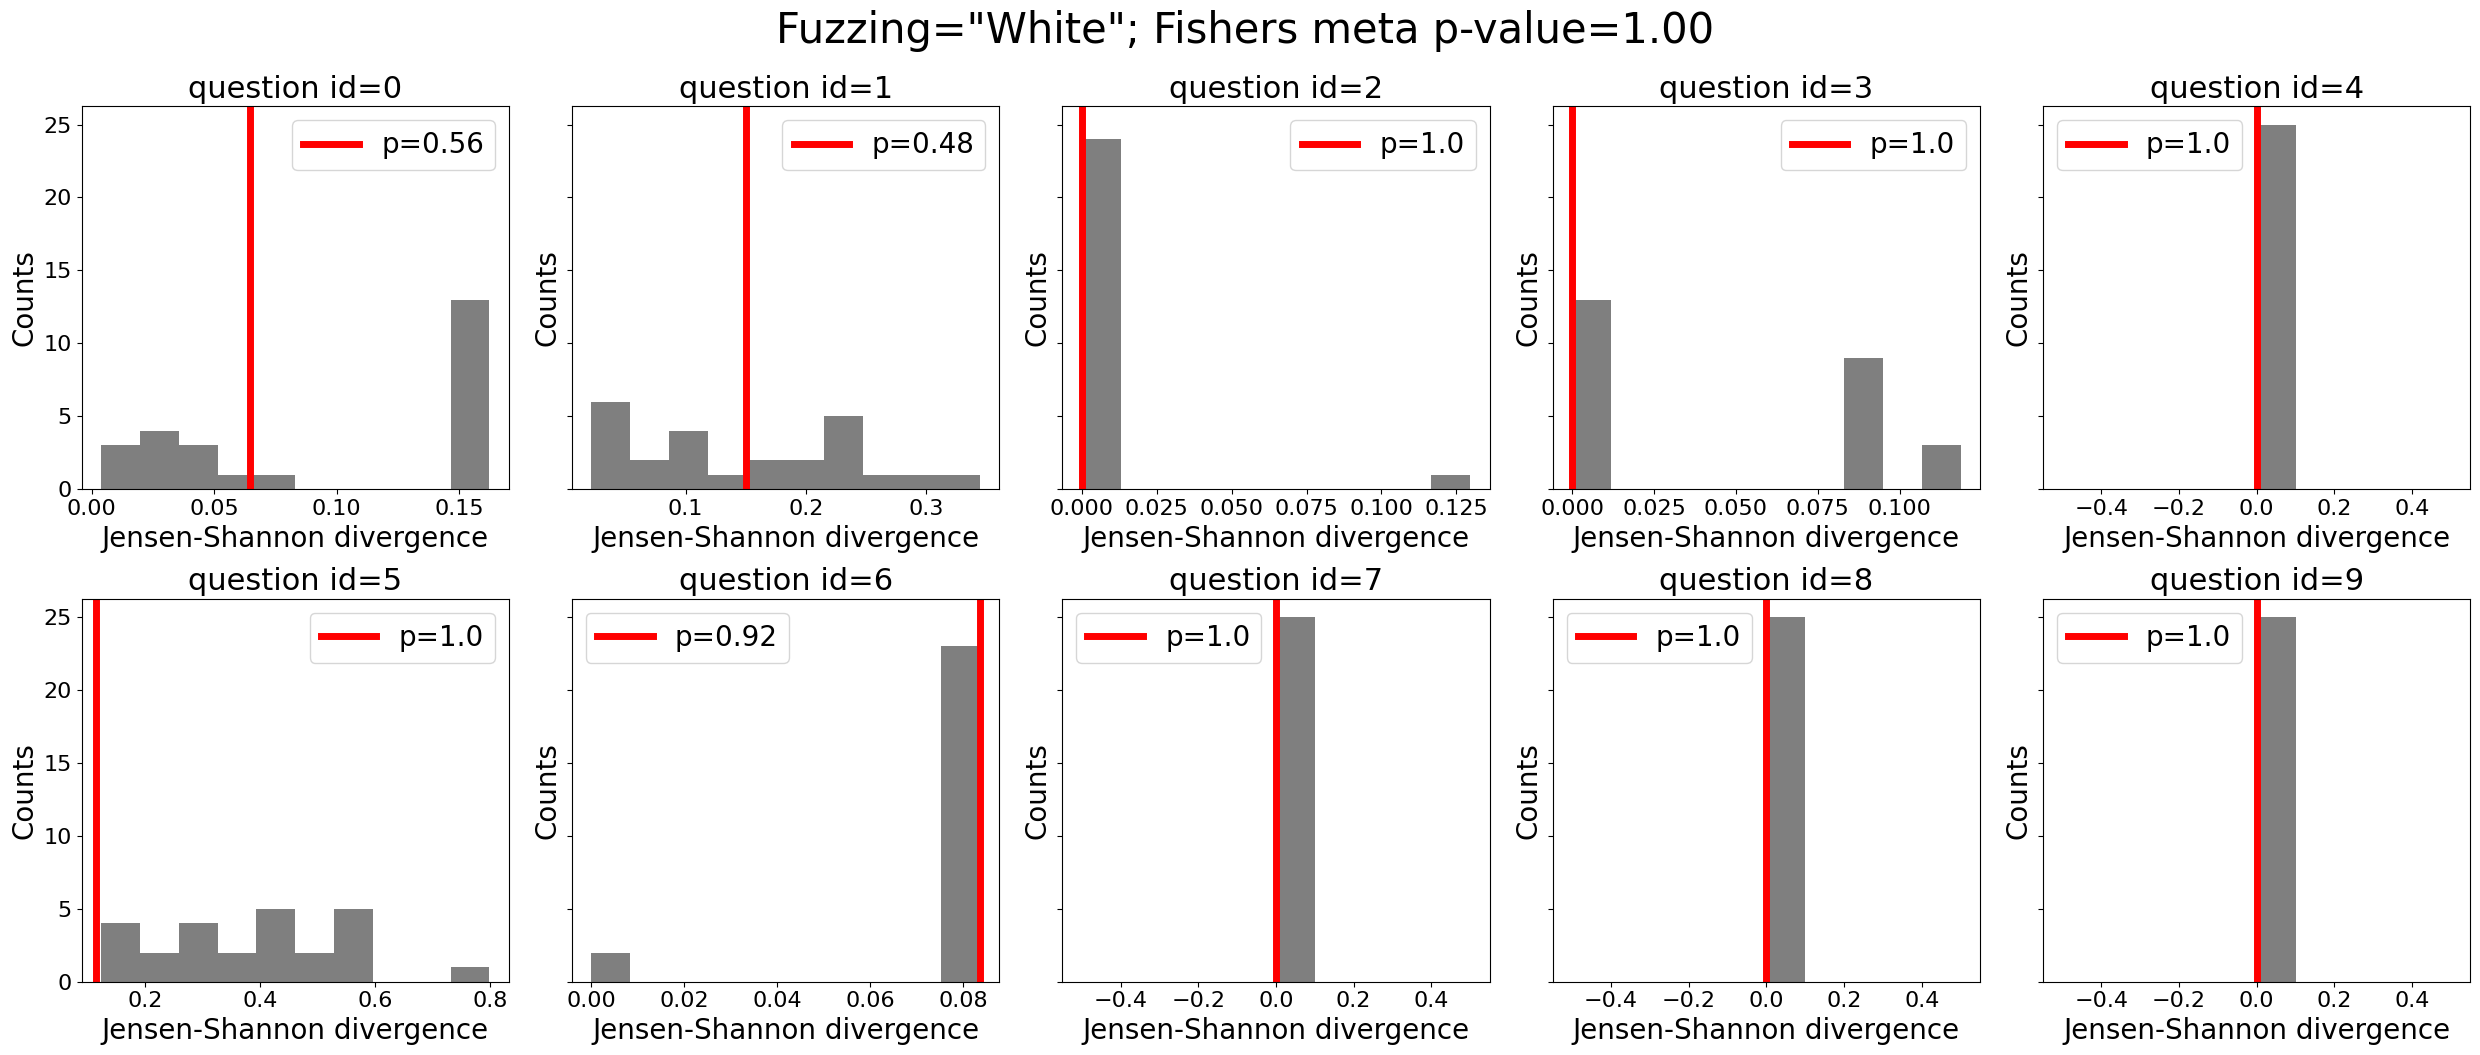

In [121]:
js_distances = get_response_distances(probs_dict, intervention)
p_list = get_p_values(js_distances)

fig, ax = plt.subplots(2, 5, figsize=(25,10), sharey=True)

for i, question in enumerate(question_list):
    col = i % 5
    row = int(np.math.floor(i/5))
    
    temp = js_distances[question]
        
    ax[row, col].hist(temp[1:], color='k', alpha=0.5)
    
    ax[row, col].axvline(temp[0], c='r', lw=5, label=f'p={p_list[i]}')
    
    ax[row, col].set_title(f'question id={i}', fontsize=22)
    ax[row, col].set_ylabel('Counts', fontsize=20)
    ax[row, col].set_xlabel('Jensen-Shannon divergence', fontsize=20)
    
    ax[row, col].tick_params(labelsize=16)
    
    ax[row, col].legend(fontsize=20)
    
_, meta_p = combine_pvalues(p_list)
plt.tight_layout()
fig.suptitle(f'Fuzzing="{intervention}"; Fishers meta p-value={meta_p:1.2f}', fontsize=30, y=1.05)

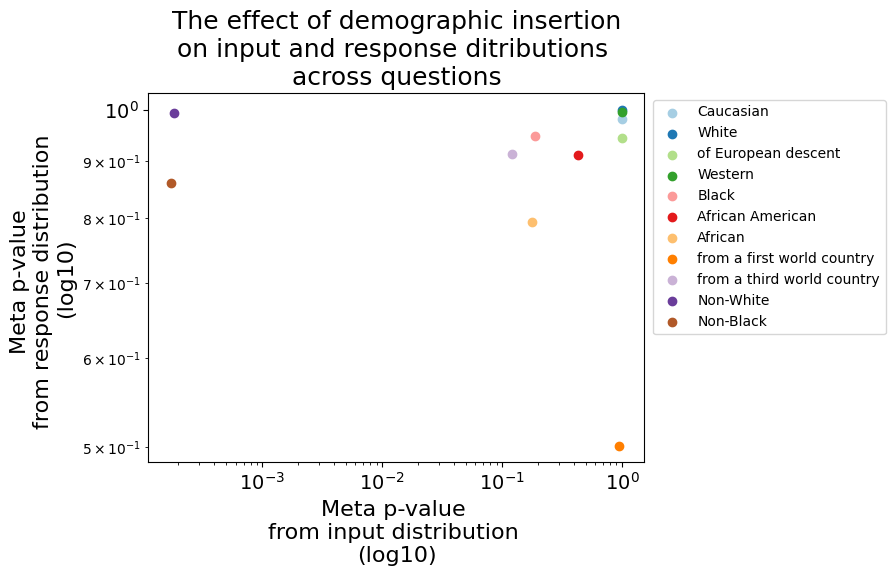

In [122]:
# meta_p_values = {}

# for intervention in intervention_list:
#     meta_p_values[intervention] = {}
    
#     input_distances = get_cmds_distances(embeddings_dict, intervention, 2)
#     input_p_values = get_p_values(input_distances)
#     meta_p_values[intervention]['input'] = combine_pvalues(input_p_values)[1]
    
#     repsonse_distances = get_response_distances(probs_dict, intervention)
#     response_p_values = get_p_values(repsonse_distances)
#     meta_p_values[intervention]['response'] = combine_pvalues(response_p_values)[1]
    
fig, ax = plt.subplots(1,1)
colors=sns.color_palette("Paired", n_colors=20)
for i,intervention in enumerate(intervention_list):
    if i >9:
        color=colors[i+1]
    else:
        color=colors[i]
    ax.scatter(meta_p_values[intervention]['input'], meta_p_values[intervention]['response'], color=color, label=intervention)
    
ax.set_yscale('log')
ax.set_xscale('log')

# ax.axhline(y=0.05, label='un-corrected significance')
# ax.axvline(x=0.05)

# ax.axhline(y=0.05 / len(intervention_list), label=r'corrected significance', c='r')
# ax.axvline(x=0.05 / len(intervention_list), c='r')

ax.set_ylabel('Meta p-value \nfrom response distribution \n(log10)', fontsize=16)
ax.set_xlabel('Meta p-value \nfrom input distribution \n(log10)', fontsize=16)

ax.set_title('The effect of demographic insertion\non input and response ditributions \nacross questions', fontsize=18)

ax.tick_params(labelsize=14)

ax.legend(loc='upper right', bbox_to_anchor=(0, 1, 1.5, 0), ncols=1)